In [138]:
import numpy as  np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cdist 
from scipy.special import kv, gamma

from sklearn.metrics import root_mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [139]:
def kriging(x, X, Y, sigma, cov):
    '''
    x : prediction point
    X : the vector of observation points
    Y : observations
    sigma : covariance matrix of observations
    cov : covariance function cov(h) 
    '''
    return cov(cdist(x, X)) @ np.linalg.solve(sigma, Y)

def var_kriging(x, X, sigma, cov):
    k_x_X = np.nan_to_num(cov(cdist(x, X)), nan=1)
    return 1 - np.diag(k_x_X @ np.linalg.solve(sigma, k_x_X.T))

In [140]:
def cov_matrix(cov_model, X_1, X_2, rho=1):
    return rho * np.nan_to_num(cov_model(cdist(X_1,X_2)), nan=1)

def k(X_1, X_2, cov_1, cov_2, cov_12, rho_12):
    return np.block([[cov_matrix(cov_1, X_1, X_2), cov_matrix(cov_12, X_1, X_2, rho_12)], 
                     [cov_matrix(cov_12, X_1, X_2, rho_12), cov_matrix(cov_2, X_1, X_2)]])    

# PENSANDO EN DIFERENTES PUNTOS DE OBSERVACION SEGUN CADA VARIABLE Y_i 
def K(X_1, X_2, cov_1, cov_2, cov_12, rho_12):
    return np.block([[cov_matrix(cov_1, X_1, X_1), cov_matrix(cov_12, X_1, X_2, rho_12)], 
                     [cov_matrix(cov_12, X_2, X_1, rho_12), cov_matrix(cov_2, X_2, X_2)]])

In [141]:
def co_kriging(x, X, Y, cov_1, cov_2, cov_12, rho_12, sigma):
    'si x es un conjunto de puntos, entrega las predicciones (Y_1.T, Y_2.T).T'
    c = k(x, X, cov_1, cov_2, cov_12, rho_12)
    return c @ np.linalg.solve(sigma, Y)

In [563]:
def nestedCoKriging(x, X, Y_1, Y_2, A, cov_1, cov_2, cov_12, rho_12):
    '''
    x : prediction point
    X : the vector of all observation points
    Y_1 : all observations of random field Y_1
    Y_2 : all observations of random field Y_2
    A : list of list with submodels indexes
    cov_ij : covariance function between Y_i and Y_j
    '''
    M = np.zeros((2 * len(A), 1))
    k_M = np.zeros((2 * len(A), 2))
    K_M = np.zeros((2 * len(A), 2 * len(A)))

    for i in range(len(A)):
        k_x_X_i = k(x, X[A[i]], cov_1, cov_2, cov_12, rho_12)
        k_X_X_i = k(X[A[i]], X[A[i]], cov_1, cov_2, cov_12, rho_12)
        
        M[2*i:(2*i+2), :] = k_x_X_i @ np.linalg.solve(k_X_X_i, np.concatenate([Y_1[A[i]], Y_2[A[i]]]))
        k_M[2*i:(2*i+2), :] = k_x_X_i @ np.linalg.solve(k_X_X_i, k_x_X_i.T)
        K_M[2*i:(2*i+2),2*i:(2*i+2)] = k_M[2*i:(2*i+2), :]
        for j in range(i+1, len(A)):
            k_x_X_j = k(x, X[A[j]], cov_1, cov_2, cov_12, rho_12)
            k_X_X_j = k(X[A[j]], X[A[j]], cov_1, cov_2, cov_12, rho_12)
            k_X_i_X_j = k(X[A[i]], X[A[j]], cov_1, cov_2, cov_12, rho_12)
            
            K_M[2*i:(2*i+2),2*j:(2*j+2)] = np.linalg.solve(k_X_X_i, k_x_X_i.T).T @ k_X_i_X_j @ np.linalg.solve(k_X_X_j, k_x_X_j.T)  
            K_M[2*j:(2*j+2),2*i:(2*i+2)] = K_M[2*i:(2*i+2),2*j:(2*j+2)].T

    return k_M.T @ np.linalg.solve(K_M, M)

In [ ]:
def nestedCoKriging(x, X, Y_1, Y_2, A, cov_1, cov_2, cov_12, rho_12):
    '''
    x : prediction point
    X : the vector of all observation points
    Y_1 : all observations of random field Y_1
    Y_2 : all observations of random field Y_2
    A : list of list with submodels indexes
    cov_ij : covariance function between Y_i and Y_j
    '''
    M = np.zeros((2 * len(A), 1))
    k_M = np.zeros((2 * len(A), 2))
    K_M = np.zeros((2 * len(A), 2 * len(A)))

    for i in range(len(A)):
        k_x_X_i = k(x, X[A[i]], cov_1, cov_2, cov_12, rho_12)
        k_X_X_i = k(X[A[i]], X[A[i]], cov_1, cov_2, cov_12, rho_12)
        
        M[2*i:(2*i+2), :] = (k_x_X_i @ np.linalg.solve(k_X_X_i, np.concatenate([Y_1[A[i]], Y_2[A[i]]]))).reshape((2,1))
        k_M[2*i:(2*i+2), :] = k_x_X_i @ np.linalg.solve(k_X_X_i, k_x_X_i.T)
        K_M[2*i:(2*i+2),2*i:(2*i+2)] = k_M[2*i:(2*i+2), :]
        for j in range(i+1, len(A)):
            k_x_X_j = k(x, X[A[j]], cov_1, cov_2, cov_12, rho_12)
            k_X_X_j = k(X[A[j]], X[A[j]], cov_1, cov_2, cov_12, rho_12)
            k_X_i_X_j = k(X[A[i]], X[A[j]], cov_1, cov_2, cov_12, rho_12)
            
            K_M[2*i:(2*i+2),2*j:(2*j+2)] = np.linalg.solve(k_X_X_i, k_x_X_i.T).T @ k_X_i_X_j @ np.linalg.solve(k_X_X_j, k_x_X_j.T)  
            K_M[2*j:(2*j+2),2*i:(2*i+2)] = K_M[2*i:(2*i+2),2*j:(2*j+2)].T

    return k_M.T @ np.linalg.solve(K_M, M)

Matérn con $K_\nu$

In [564]:
matern_model = lambda t, nu: np.vectorize(lambda x: 2**(1-nu) / gamma(nu) * (t*x)**nu * kv(nu, t*x))

Parameters

In [565]:
d = 1
# n = m = 5

nu_1 = 12
theta_1 = 12.5

nu_2 = 5
theta_2 = 18

nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = -(theta_12**2/(theta_1*theta_2))**(d/2) * ( gamma(nu_1+d/2)*gamma(nu_2+d/2) / (gamma(nu_1)*gamma(nu_2)) )**(1/2) * gamma(nu_12)/gamma(nu_12+d/2)
rho_12

-0.7931385942329555

Example $d=1$

In [566]:
X = np.array([[0.1],[0.3],[0.5],[0.7],[0.9]])

f_1 = lambda x : np.sin(2 * np.pi * x) + x
f_2 = lambda x : np.cos(2 * np.pi * x + np.pi/2) - x

Y_1 = f_1(X)
Y_2 = f_2(X)

Covariance matrices

In [567]:
sigma_1 = cov_matrix(matern_model(theta_1, nu_1), X, X, rho=1)
sigma_2 = cov_matrix(matern_model(theta_2, nu_2), X, X, rho=1)
sigma_12 = cov_matrix(matern_model(theta_12, nu_12), X, X, rho=rho_12)

In [568]:
X_aux = np.linspace(-0.5,1.5,500).reshape((500,1))
Y_aux_1 = f_1(X_aux)
Y_aux_2 = f_2(X_aux)

In [569]:
A = [[0,1,2], [3,4]]

In [570]:
np.corrcoef(Y_1.reshape(-1), Y_2.reshape(-1))[0,1]

-0.9999999999999998

In [571]:
sigma = np.block([[sigma_1, sigma_12],
                  [sigma_12.T, sigma_2]])

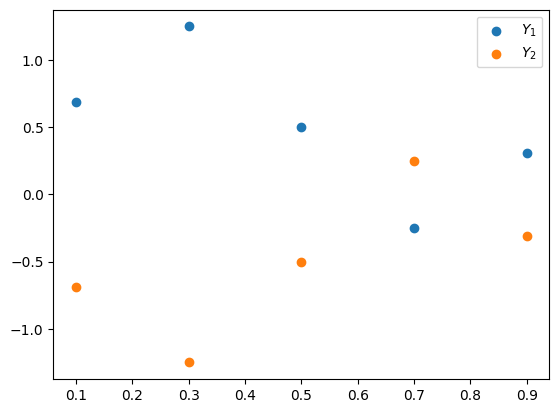

In [572]:
plt.scatter(X, Y_1, label = r'$Y_1$')
plt.scatter(X, Y_2, label = r'$Y_2$')
plt.legend();

Kriging con bandas de confianza del 95%

In [573]:
Y_1_K = kriging(X_aux, X[A[0]], Y_1[A[0]], sigma_1[A[0]][:,A[0]], matern_model(theta_1, nu_1))

In [574]:
var_1 = var_kriging(X_aux, X[A[0]], sigma_1[A[0]][:,A[0]], matern_model(theta_1, nu_1))

In [575]:
def plot_(X, Y, variance, n):
    plt.plot(X, Y.flatten(), c='b')
    plt.plot(X, Y.flatten() - 1.96 * np.sqrt(variance) / n, ls='--', c='b', lw=1)
    plt.plot(X, Y.flatten() + 1.96 * np.sqrt(variance) / n, ls='--', c='b', lw=1)

    plt.fill_between(X.flatten(),
                     Y.flatten() - 1.96 * np.sqrt(variance) / n, 
                     Y.flatten() + 1.96 * np.sqrt(variance) / n, 
                     color='blue', alpha=0.1)

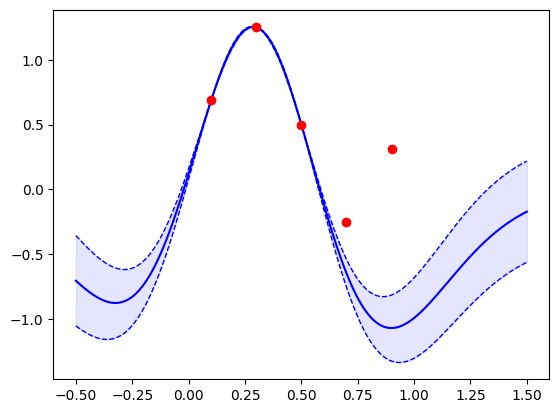

In [576]:
plt.scatter(X, Y_1, zorder=3, c='r')
plot_(X_aux, Y_1_K, var_1, len(X))

In [577]:
Y_1_K = kriging(X_aux, X, Y_1, sigma_1, matern_model(theta_1, nu_1))
Y_2_K = kriging(X_aux, X, Y_2, sigma_2, matern_model(theta_2, nu_2))

In [578]:
Y_coK = co_kriging(X_aux, X, np.concatenate([Y_1, Y_2]), 
               matern_model(theta_1, nu_1), 
               matern_model(theta_2, nu_2), 
               matern_model(theta_12, nu_12),
               rho_12,
               sigma
            )
Y_1_coK = Y_coK[:len(X_aux)]
Y_2_coK = Y_coK[len(X_aux):]

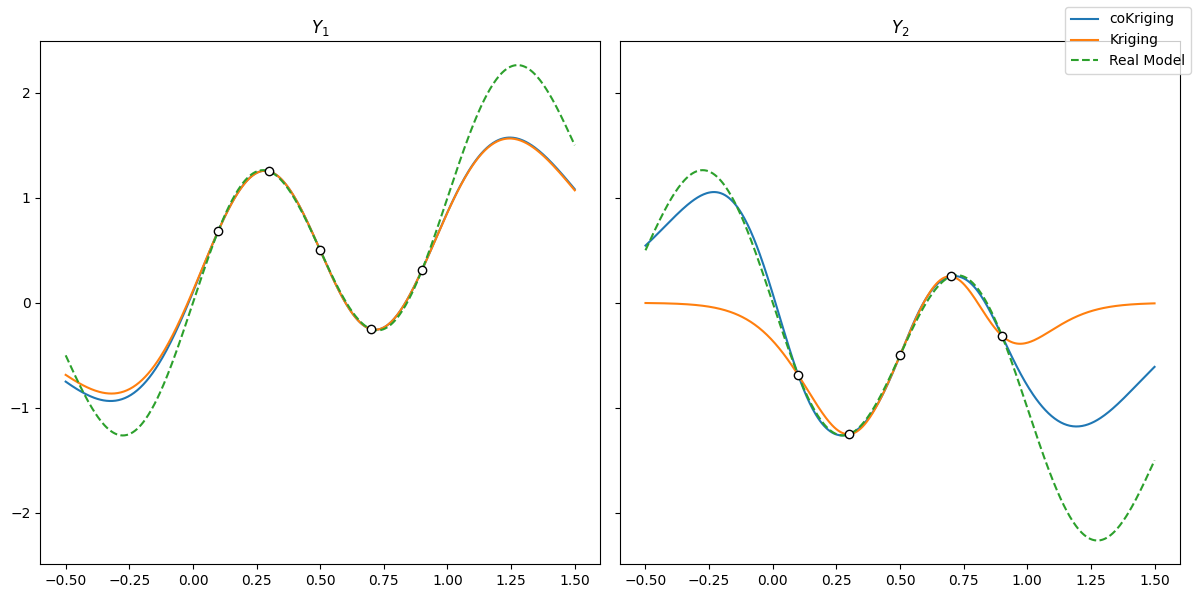

In [579]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6), sharey=True)

ax1.scatter(X, Y_1, edgecolors='k', c='w', zorder=3)
ax1.plot(X_aux, Y_1_coK, label='coKriging')
ax1.plot(X_aux, Y_1_K, label='Kriging')
ax1.plot(X_aux, Y_aux_1, ls='--', label='Real Model')
ax1.set_title(r'$Y_1$')

ax2.scatter(X, Y_2, edgecolors='k', c='w', zorder=3)
ax2.plot(X_aux, Y_2_coK)
ax2.plot(X_aux, Y_2_K)
ax2.plot(X_aux, Y_aux_2, ls='--')
ax2.set_title(r'$Y_2$')

fig.legend()
fig.tight_layout();

Nested CoKriging

In [580]:
sigma = np.block([[sigma_1[A[0]][:,A[0]], sigma_12[A[0]][:,A[0]]],
                  [sigma_12[A[0]][:,A[0]].T, sigma_2[A[0]][:,A[0]]]])

In [581]:
Y_coK = co_kriging(X_aux, X[A[0]], np.concatenate([Y_1[A[0]], Y_2[A[0]]]), 
               matern_model(theta_1, nu_1), 
               matern_model(theta_2, nu_2), 
               matern_model(theta_12, nu_12),
               rho_12,
               np.block([[sigma_1[A[0]][:,A[0]], sigma_12[A[0]][:,A[0]]],
                         [sigma_12[A[0]][:,A[0]].T, sigma_2[A[0]][:,A[0]]]])
            )
Y_1_coK_1 = Y_coK[:len(X_aux)]
Y_2_coK_1 = Y_coK[len(X_aux):]

In [582]:
Y_coK = co_kriging(X_aux, X[A[1]], np.concatenate([Y_1[A[1]], Y_2[A[1]]]), 
               matern_model(theta_1, nu_1), 
               matern_model(theta_2, nu_2), 
               matern_model(theta_12, nu_12),
               rho_12,
               np.block([[sigma_1[A[1]][:,A[1]], sigma_12[A[1]][:,A[1]]],
                         [sigma_12[A[1]][:,A[1]].T, sigma_2[A[1]][:,A[1]]]])
            )
Y_1_coK_2 = Y_coK[:len(X_aux)]
Y_2_coK_2 = Y_coK[len(X_aux):]

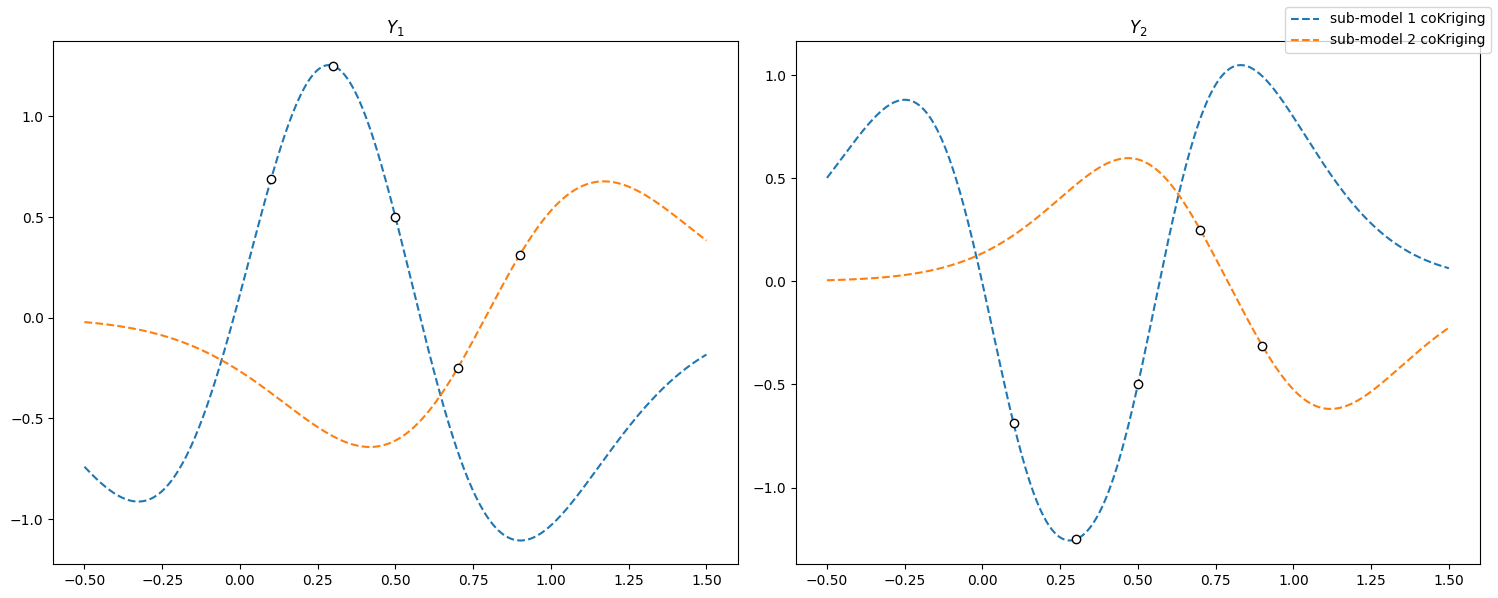

In [583]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

ax1.scatter(X, Y_1, edgecolors='k', c='w', zorder=3)
ax1.plot(X_aux, Y_1_coK_1, ls='--', label='sub-model 1 coKriging')
ax1.plot(X_aux, Y_1_coK_2, ls='--', label='sub-model 2 coKriging')
ax1.set_title(r'$Y_1$')

ax2.scatter(X, Y_2, edgecolors='k', c='w', zorder=3)
ax2.plot(X_aux, Y_2_coK_1, ls='--')
ax2.plot(X_aux, Y_2_coK_2, ls='--')
ax2.set_title(r'$Y_2$')

fig.legend()
fig.tight_layout();

Aggregated

In [584]:
Y_NcoK = np.hstack([nestedCoKriging(X_aux[[i]], X, Y_1, Y_2, A,
                                    matern_model(theta_1, nu_1),
                                    matern_model(theta_2, nu_2),
                                    matern_model(theta_12, nu_12),
                                    rho_12) for i in range(len(X_aux))])

In [585]:
Y_1_NcoK = Y_NcoK[0]
Y_2_NcoK = Y_NcoK[1]

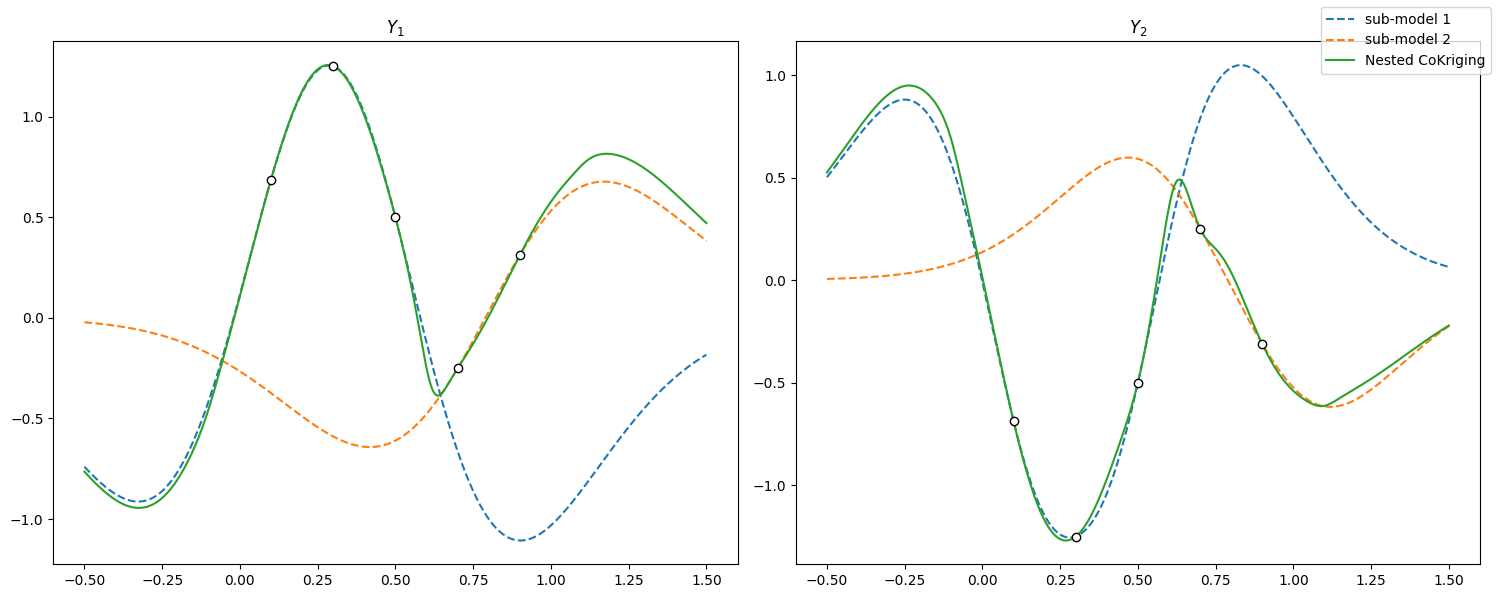

In [586]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

ax1.scatter(X, Y_1, edgecolors='k', c='w', zorder=3)
ax1.plot(X_aux, Y_1_coK_1, ls='--', label='sub-model 1')
ax1.plot(X_aux, Y_1_coK_2, ls='--', label='sub-model 2')
ax1.plot(X_aux, Y_1_NcoK, label='Nested CoKriging')
ax1.set_title(r'$Y_1$')

ax2.scatter(X, Y_2, edgecolors='k', c='w', zorder=3)
ax2.plot(X_aux, Y_2_coK_1, ls='--')
ax2.plot(X_aux, Y_2_coK_2, ls='--')
ax2.plot(X_aux, Y_2_NcoK)
ax2.set_title(r'$Y_2$')

fig.legend()
fig.tight_layout();

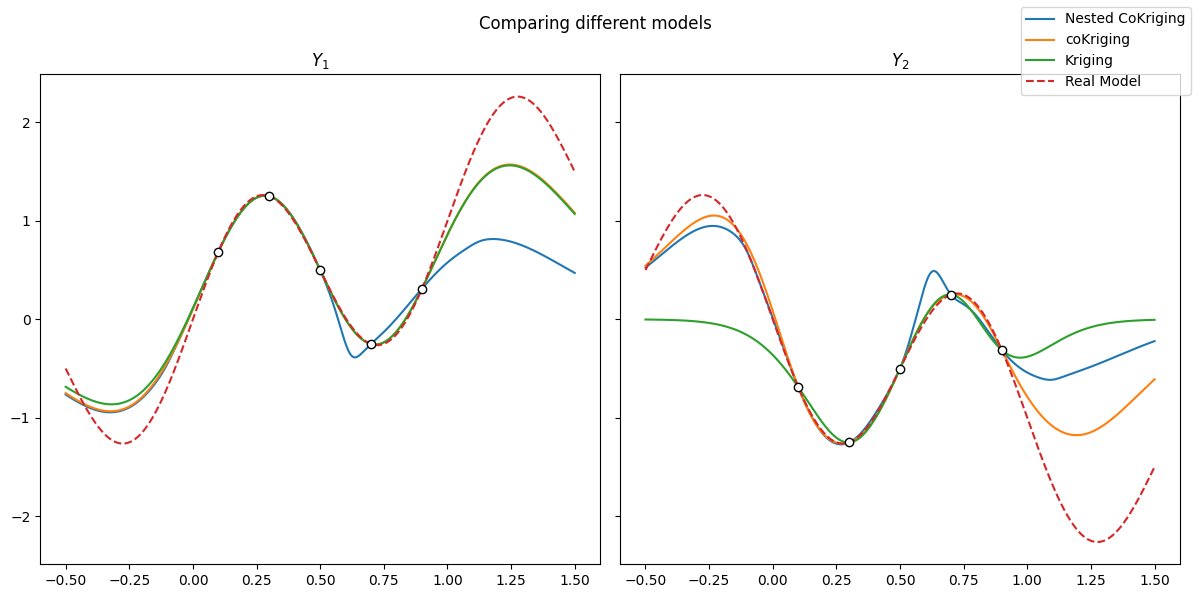

In [587]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6), sharey=True)

ax1.scatter(X, Y_1, edgecolors='k', c='w', zorder=3)
ax1.plot(X_aux, Y_1_NcoK, label='Nested CoKriging')
ax1.plot(X_aux, Y_1_coK, label='coKriging')
ax1.plot(X_aux, Y_1_K, label='Kriging')
ax1.plot(X_aux, Y_aux_1, ls='--', label='Real Model')
ax1.set_title(r'$Y_1$')

ax2.scatter(X, Y_2, edgecolors='k', c='w', zorder=3)
ax2.plot(X_aux, Y_2_NcoK)
ax2.plot(X_aux, Y_2_coK)
ax2.plot(X_aux, Y_2_K)
ax2.plot(X_aux, Y_aux_2, ls='--')
ax2.set_title(r'$Y_2$')

fig.suptitle('Comparing different models')
fig.legend()
fig.tight_layout();

In [588]:
results = []
results.append(('Kriging', root_mean_squared_error(Y_aux_1, Y_1_K), root_mean_squared_error(Y_aux_2, Y_2_K)))
results.append(('coKriging', root_mean_squared_error(Y_aux_1, Y_1_coK), root_mean_squared_error(Y_aux_2, Y_2_coK)))
results.append(('Nested coKriging', root_mean_squared_error(Y_aux_1, Y_1_NcoK), root_mean_squared_error(Y_aux_2, Y_2_NcoK)))

In [589]:
df = pd.DataFrame(data=results, columns=['Método', 'RMSE Y_1', 'RMSE Y_2'])
df

,Método,RMSE Y_1,RMSE Y_2
0,Kriging,0.318586,1.040762
1,coKriging,0.305058,0.479254
2,Nested coKriging,0.631791,0.754123


Example $d=2$

In [590]:
d = 2
n = 500
sup = n
X = np.random.uniform(0, sup, (n,d))

In [591]:
nu_1 = 11/2
theta_1 = 50/sup

nu_2 = 7/2
theta_2 = 70/sup

nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = (theta_12**2/(theta_1*theta_2))**(d/2) * ( gamma(nu_1+d/2)*gamma(nu_2+d/2) / (gamma(nu_1)*gamma(nu_2)) )**(1/2) * gamma(nu_12)/gamma(nu_12+d/2)

In [592]:
sigma = k(X, X, 
          matern_model(theta_1, nu_1), 
          matern_model(theta_2, nu_2), 
          matern_model(theta_12, nu_12),
          rho_12)

In [593]:
Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, 2*n)

Y_1 = Y[:n]
Y_2 = Y[n:]

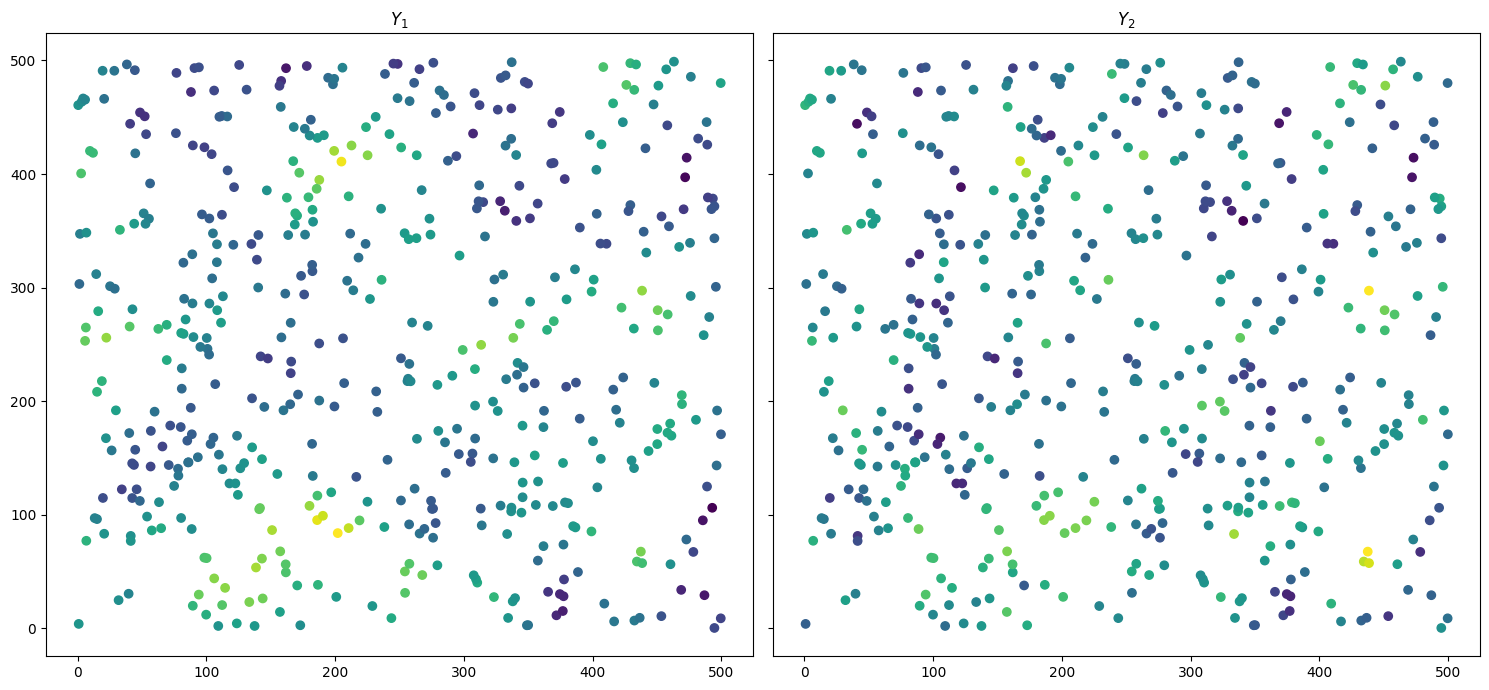

In [594]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,7))

ax1.scatter(X[:,0], X[:,1], c=Y_1)
ax1.set_title(r'$Y_1$')
ax2.scatter(X[:,0], X[:,1], c=Y_2)
ax2.set_title(r'$Y_2$')
fig.tight_layout();

Test set

In [595]:
n_test = 100
sup = n
X_test = np.random.uniform(0, sup, (n_test,d))
sigma_test = k(X_test, X_test, 
          matern_model(theta_1, nu_1), 
          matern_model(theta_2, nu_2), 
          matern_model(theta_12, nu_12),
          rho_12)
Y_test = np.linalg.cholesky(sigma_test) @ np.random.normal(0, 1, 2*n_test)

Y_1_test = Y_test[:n_test]
Y_2_test = Y_test[n_test:]

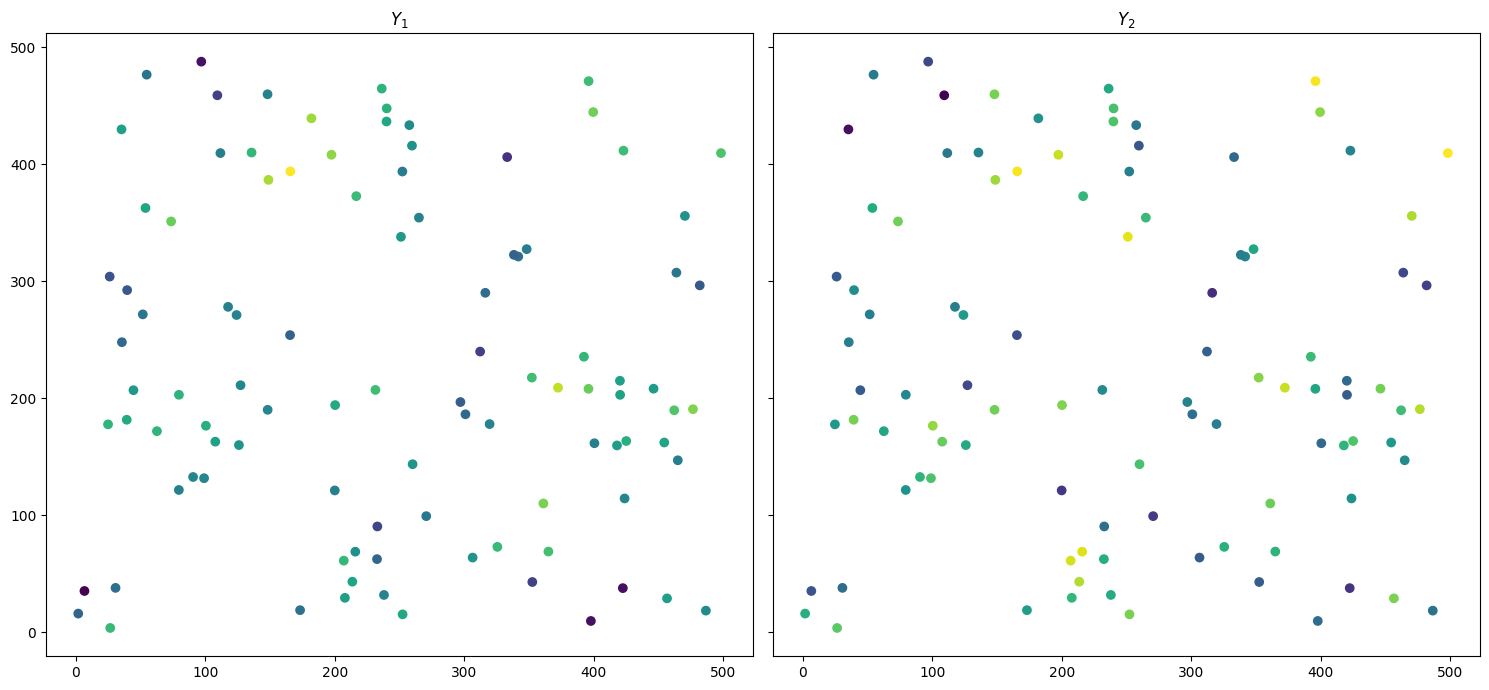

In [596]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,7))

ax1.scatter(X_test[:,0], X_test[:,1], c=Y_1_test)
ax1.set_title(r'$Y_1$')
ax2.scatter(X_test[:,0], X_test[:,1], c=Y_2_test)
ax2.set_title(r'$Y_2$')

fig.tight_layout();

In [597]:
Y_coK = co_kriging(X_test, X, Y, 
                   matern_model(theta_1, nu_1), 
                   matern_model(theta_2, nu_2), 
                   matern_model(theta_12, nu_12),
                   rho_12, sigma)

Y_1_coK = Y_coK[:len(X_test)]
Y_2_coK = Y_coK[len(X_test):]

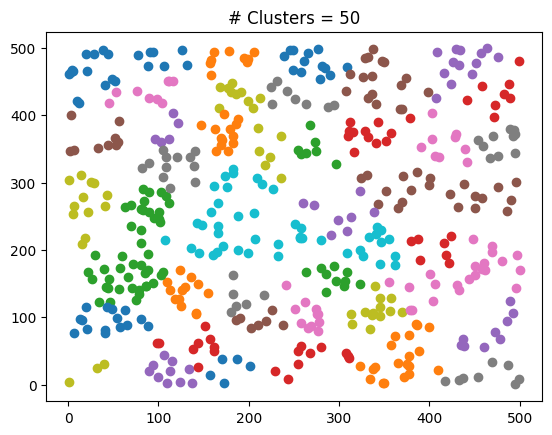

In [628]:
from sklearn.cluster import KMeans

n_clusters = 50
KM = KMeans(n_clusters=n_clusters).fit(X)

A = [[] for _ in range(n_clusters)]
for i, label in enumerate(KM.labels_):
    A[label].append(i)
    
for i in range(len(A)):
    plt.scatter(X[A[i], 0], X[A[i], 1])
plt.title(f'# Clusters = {n_clusters}');

In [629]:
def nestedCoKriging(x, X, Y_1, Y_2, A, cov_1, cov_2, cov_12, rho_12):
    '''
    x : prediction point
    X : the vector of all observation points
    Y_1 : all observations of random field Y_1
    Y_2 : all observations of random field Y_2
    A : list of list with submodels indexes
    cov_ij : covariance function between Y_i and Y_j
    '''
    M = np.zeros((2 * len(A), 1))
    k_M = np.zeros((2 * len(A), 2))
    K_M = np.zeros((2 * len(A), 2 * len(A)))

    for i in range(len(A)):
        k_x_X_i = k(x, X[A[i]], cov_1, cov_2, cov_12, rho_12)
        k_X_X_i = k(X[A[i]], X[A[i]], cov_1, cov_2, cov_12, rho_12)
        
        M[2*i:(2*i+2), :] = (k_x_X_i @ np.linalg.solve(k_X_X_i, np.concatenate([Y_1[A[i]], Y_2[A[i]]]))).reshape((2,1))
        k_M[2*i:(2*i+2), :] = k_x_X_i @ np.linalg.solve(k_X_X_i, k_x_X_i.T)
        K_M[2*i:(2*i+2),2*i:(2*i+2)] = k_M[2*i:(2*i+2), :]
        for j in range(i+1, len(A)):
            k_x_X_j = k(x, X[A[j]], cov_1, cov_2, cov_12, rho_12)
            k_X_X_j = k(X[A[j]], X[A[j]], cov_1, cov_2, cov_12, rho_12)
            k_X_i_X_j = k(X[A[i]], X[A[j]], cov_1, cov_2, cov_12, rho_12)
            
            K_M[2*i:(2*i+2),2*j:(2*j+2)] = np.linalg.solve(k_X_X_i, k_x_X_i.T).T @ k_X_i_X_j @ np.linalg.solve(k_X_X_j, k_x_X_j.T)  
            K_M[2*j:(2*j+2),2*i:(2*i+2)] = K_M[2*i:(2*i+2),2*j:(2*j+2)].T

    return k_M.T @ np.linalg.solve(K_M, M)

In [634]:
Y_NcoK = np.hstack([nestedCoKriging(X_test[[i]], X, Y_1, Y_2, A,
                                    matern_model(theta_1, nu_1),
                                    matern_model(theta_2, nu_2),
                                    matern_model(theta_12, nu_12),
                                    rho_12) for i in range(len(X_test))])

In [651]:
Y_1_NcoK = Y_NcoK[0]
Y_2_NcoK = Y_NcoK[1]

In [652]:
Y_1_K = kriging(X_test, X, Y_1, sigma[:n,:n], matern_model(theta_1, nu_1))
Y_2_K = kriging(X_test, X, Y_2, sigma[-n:,-n:], matern_model(theta_2, nu_2))

In [655]:
results = []
results.append(('Kriging', root_mean_squared_error(Y_1_test, Y_1_K), root_mean_squared_error(Y_2_test, Y_2_K)))
results.append(('coKriging', root_mean_squared_error(Y_1_test, Y_1_coK), root_mean_squared_error(Y_2_test, Y_2_coK)))
results.append(('Nested coKriging', root_mean_squared_error(Y_1_test, Y_1_NcoK), root_mean_squared_error(Y_2_test, Y_2_NcoK)))

In [656]:
df = pd.DataFrame(data=results, columns=['Método', 'RMSE Y_1', 'RMSE Y_2'])
df

,Método,RMSE Y_1,RMSE Y_2
0,Kriging,1.208140,1.250463
1,coKriging,1.206230,1.243846
2,Nested coKriging,1.199565,1.236631
